## Introduction
In this assignment, you will learn how to build a language model from scratch and use the model to generate new text.
You will also see how training a language model helps you learn word representation.

Note: 
- Plagiarism will result in 0 mark.
- The following template shows how your code should look like. You are free to add more functions, change the parameters. You are not allowed to use existing implementations.


In [1]:
import torch
import torch.nn as nn
import torch.autograd as ag
import numpy as np
from matplotlib import pyplot as plt
import math 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Recurrent Neural Network (5 points)
To begin, you have to implement the vanila RNN in Pytorch.

### Vanila RNN
Recall the formula for vanila RNN:
        \begin{eqnarray}
        h_t & = & \sigma(W_h h_{t-1} + W_x x_t + b_1) \\
        y_t & = & \phi(W_y h_t + b_2)
        \end{eqnarray}
where $\sigma$ is the usually the sigmoid activation function and $\phi$ is usually the softmax function.

Hints:
For RNNLM, the input is a squence of word_id, e.g. [10, 8, 5, 2, 101, 23]. You have to convert each word_id to an embedding vector. To implement this, you can use the `torch.nn.Embedding` class.

In [2]:
class VanilaRNNLM(nn.Module):
    def __init__(self, n_inputs, n_hiddens, n_outputs, sigma='sigmoid', phi='softmax'):
        """
        Construct a vanila RNN. 
        
        Params:
        n_inputs: number of input neurons = 1 x embedding_dim
        n_hiddens: number of hidden neurons 
        n_outputs: number of output neurons = 1 x vocab_size
        sigma: activation function for hidden layer
        phi: output function
        """
        super(VanilaRNNLM, self).__init__()

        self.embeddings = nn.Embedding(n_outputs, n_inputs)
        self.n_hiddens = n_hiddens

        self.W_e = nn.Parameter(torch.Tensor(n_inputs, n_hiddens).to(device))
        self.W_h = nn.Parameter(torch.Tensor(n_hiddens, n_hiddens).to(device))
        self.b1 = nn.Parameter(torch.zeros(1, n_hiddens).to(device))
        
        self.W_y = nn.Parameter(torch.Tensor(n_hiddens, n_outputs).to(device))
        self.b2 = nn.Parameter(torch.zeros(1, n_outputs))

        # initialize weights
        nn.init.uniform_(self.embeddings.weight, -1.0, 1.0)
        nn.init.xavier_normal_(self.W_e)
        nn.init.xavier_normal_(self.W_h)
        nn.init.xavier_normal_(self.W_y)

        if (sigma == 'sigmoid'):
          self.sigma = nn.Sigmoid()
        if (phi == 'softmax'):
          # ignore (implemented in CE loss function)
          pass
    
    def forward(self, xs, h0):
        """
        Params:
        xs: the input sequence [x_1, x_2, ..., x_n]. x_i is the id of the i-th word in the sequence. 
            For example, xs = [1, 3, 11, 6, 8, 2]
        h0: the initial hidden state
        
        Returns: (ys, hs) where
        ys = [y_1, y_2, ..., y_n] and
        hs = [h_1, h_2, ..., h_n]
        """
        # embedded sequence [e_1, e_2, ..., e_n]    n x embedding_dim
        es = self.embeddings(xs)  
        #.view((1, -1))

        Time_steps = len(es)
        hs = []
        ys = []

        for t in range(Time_steps):
          if (t==0):
            # h_1 = sigmoid(W_h * h0 + W_e * e_1 + b1)  
            h_t = torch.matmul(h0, self.W_h) + torch.matmul(es[t], self.W_e)  + self.b1
            h_t = self.sigma(h_t)
            hs.append(h_t)
          else:
            # h_t = sigmoid(W_h * h_(t-1) + W_e * e_t + b1)  
            h_t = torch.matmul(hs[t-1], self.W_h) + torch.matmul(es[t], self.W_e)  + self.b1
            h_t = self.sigma(h_t)
            hs.append(h_t)
          # y_t = softmax(W_y * h_t + b2)
          y_t = torch.matmul(hs[t], self.W_y) + self.b2
          ys.append(y_t)

        return ys, hs
        

### Fancy RNN
Vanila RNN suffers from the gradient vanishing/exploding problem. Your next task is to implement a more sophisticated RNN that is more robust to gradient vanishing/exploding.

LSTM (Long Short term memory) is a solution to this problem. the LSTM architecture makes it easier for the RNN to preserve information from many previous timesteps. So that the LSTM can learn long-distance dependencies.

$$ f^{(t)} = \sigma(W_f h^{(t-1)} + U_f x^{(t)} + b_f) $$
$$ i^{(t)} = \sigma(W_i h^{(t-1)} + U_i x^{(t)} + b_i) $$
$$ o^{(t)} = \sigma(W_o h^{(t-1)} + U_o x^{(t)} + b_o) $$

$$ g^{(t)} = \tanh(W_c h^{(t-1)} + U_c x^{(t)} + b_c) $$
$$ c^{(t)} = f^{(t)} \odot c^{(t-1)} + i^{(t)} \odot \tilde{c}^{(t)} $$
$$ h^{(t)} = o^{(t)} \odot \tanh c^{(t)} $$

In [3]:
class FancyRNNLM(nn.Module):
    def __init__(self, n_inputs, n_hiddens, n_outputs):
        """
        Construct a fancy RNN, this could be LSTM, GRU, or your own invention.
        
        Params:
        n_inputs: number of input neurons = 1 x embedding dim
        n_hiddens: number of hidden neurons
        n_outputs: number of output neurons = 1 x vocab_size
        """
        super(FancyRNNLM, self).__init__()

        self.embeddings = nn.Embedding(n_outputs, n_inputs)
        self.n_hiddens = n_hiddens

        self.W_f = nn.Parameter(torch.Tensor(n_hiddens, n_hiddens).to(device))
        self.U_f = nn.Parameter(torch.Tensor(n_inputs, n_hiddens).to(device))
        self.b_f = nn.Parameter(torch.zeros(1, n_hiddens).to(device))
        
        self.W_i = nn.Parameter(torch.Tensor(n_hiddens, n_hiddens).to(device))
        self.U_i = nn.Parameter(torch.Tensor(n_inputs, n_hiddens).to(device))
        self.b_i = nn.Parameter(torch.zeros(1, n_hiddens).to(device))

        self.W_o = nn.Parameter(torch.Tensor(n_hiddens, n_hiddens).to(device))
        self.U_o = nn.Parameter(torch.Tensor(n_inputs, n_hiddens).to(device))
        self.b_o = nn.Parameter(torch.zeros(1, n_hiddens).to(device))

        self.W_g = nn.Parameter(torch.Tensor(n_hiddens, n_hiddens).to(device))
        self.U_g = nn.Parameter(torch.Tensor(n_inputs, n_hiddens).to(device))
        self.b_g = nn.Parameter(torch.zeros(1, n_hiddens).to(device))

        # last layer before softmax
        self.fc = nn.Linear(n_hiddens, n_outputs)

        # initialize weights
        nn.init.uniform_(self.embeddings.weight, -1.0, 1.0)
        nn.init.xavier_normal_(self.W_f)
        nn.init.xavier_normal_(self.U_f)
        nn.init.xavier_normal_(self.W_i)
        nn.init.xavier_normal_(self.U_i)
        nn.init.xavier_normal_(self.W_o)
        nn.init.xavier_normal_(self.U_o)
        nn.init.xavier_normal_(self.W_g)
        nn.init.xavier_normal_(self.U_g)

    def forward(self, xs, h0):

        es = self.embeddings(xs)  

        Time_steps = len(es)
        cs = []
        hs = []
        ys = []
        c0 = torch.zeros(1, self.n_hiddens).to(device)

        for t in range(Time_steps):
          if (t==0):
            # f1 = tanh(W_g * h0 + U_g * e1 + b_g) 
            f_t = torch.sigmoid(torch.matmul(h0, self.W_f) + torch.matmul(es[t], self.U_f)  + self.b_f)
            i_t = torch.sigmoid(torch.matmul(h0, self.W_i) + torch.matmul(es[t], self.U_i)  + self.b_i)
            o_t = torch.sigmoid(torch.matmul(h0, self.W_o) + torch.matmul(es[t], self.U_o)  + self.b_o)
            # g_t = tanh(W_g * h_(t-1) + U_g * e_t + b_g) 
            g_t = torch.tanh(torch.matmul(h0, self.W_g) + torch.matmul(es[t], self.U_g)  + self.b_g)
            c_t = f_t * c0 + i_t * g_t
            cs.append(c_t)
            h_t = o_t * torch.tanh(c_t)
            hs.append(h_t)
          else:
            # f_t = sigmoid(W_f * h_(t-1) + W_f * e_t + b_f)  
            f_t = torch.sigmoid(torch.matmul(hs[t-1], self.W_f) + torch.matmul(es[t], self.U_f)  + self.b_f)
            i_t = torch.sigmoid(torch.matmul(hs[t-1], self.W_i) + torch.matmul(es[t], self.U_i)  + self.b_i)
            o_t = torch.sigmoid(torch.matmul(hs[t-1], self.W_o) + torch.matmul(es[t], self.U_o)  + self.b_o)
            # g_t = tanh(W_g * h_(t-1) + U_g * e_t + b_g) 
            g_t = torch.tanh(torch.matmul(hs[t-1], self.W_g) + torch.matmul(es[t], self.U_g)  + self.b_g)
            c_t = f_t * cs[t-1] + i_t * g_t
            cs.append(c_t)
            h_t = o_t * torch.tanh(c_t)
            hs.append(h_t)
          y_t = self.fc(h_t)
          ys.append(y_t)

        return ys, hs

## Language Modeling with RNN (4 points)
The next step is to use our RNNs in some real world tasks. One of the most common application of RNN is language modeling.

### Data
For this assignment, we will use text data from Wikipedia. To start, download the data from this website:

https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip

Some information about this dataset can be found here:

https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/



### Download and prepare data

In [4]:
from zipfile import ZipFile

# download the data
!wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip -P "/content/"

with ZipFile('/content/wikitext-103-v1.zip', 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

--2021-11-20 13:43:20--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.168.72
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.168.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190229076 (181M) [application/zip]
Saving to: ‘/content/wikitext-103-v1.zip’

wikitext-103-v1.zip 100%[===================>] 181.42M  69.9MB/s    in 2.6s    

2021-11-20 13:43:23 (69.9 MB/s) - ‘/content/wikitext-103-v1.zip’ saved [190229076/190229076]

File Name                                             Modified             Size
wikitext-103/                                  2016-09-26 17:15:24            0
wikitext-103/wiki.test.tokens                  2016-08-04 16:55:20      1281077
wikitext-103/wiki.valid.tokens                 2016-08-04 16:55:20      1142309
wikitext-103/wiki.train.tokens                 2016-08-04 16:55:20    539209157
Extracting all the files now...
Done!


In [5]:
from pathlib import Path
import re

train_data = Path('/content/wikitext-103/wiki.train.tokens').read_text()
test_data = Path('/content/wikitext-103/wiki.test.tokens').read_text()

### Preprocess Data

In [6]:
# Divide heading and article of training set
heading_regex = '( \n \n = [^=]*[^=] = \n \n )'
breakline = ' \n'
train_data = breakline + train_data
train_split = re.split(heading_regex, train_data)
train_headings = [x for x in train_split[1::2]]
train_articles = [x for x in train_split[2::2]]

test_data = breakline + test_data
test_split = re.split(heading_regex, test_data)
#test_headings = [x for x in test_split[1::2]]
test_articles = [x for x in test_split[2::2]]

print(train_headings[0])
print(train_articles[0][:100])
print(len(train_articles))

 
 
 = Valkyria Chronicles III = 
 
 
Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 
28471


In [7]:
# create vocabulary
vocabulary = set()
for article in train_articles:
  tokens = article.lower().split()
  for token in tokens:
    vocabulary.add(token)

print(len(vocabulary))

229463


In [8]:
# word2id and id2word dictionaries
word2id = {w: id for (id, w) in enumerate(vocabulary)}
id2word = {id: w for (id, w) in enumerate(vocabulary)}

for iter in range(7):
  print(str(iter) + ':' + id2word[iter])

0:em7
1:shava
2:tesreau
3:floridan
4:monarchs
5:antipolis
6:nones


In [25]:
# create corpus (train set)
corpus = []
for article in train_articles:
  sentences = article.lower().split("\n")
  for sentence in sentences:
    tokens_id = []
    sentence_to_tokens = sentence.split()
    for token in sentence_to_tokens:
      token_id = word2id[token]
      tokens_id.append(token_id)
    if (len(tokens_id) > 3):
      corpus.append(tokens_id)

print(corpus[:2])
print(len(corpus))

[[29443, 189401, 91611, 85781, 79595, 25278, 22328, 122728, 178411, 79595, 44906, 61217, 18638, 184837, 91611, 220993, 143927, 180847, 85781, 166007, 61217, 8180, 189986, 126191, 137082, 91611, 22328, 62484, 107875, 207222, 61217, 2090, 44787, 78766, 214575, 91425, 215633, 66440, 39522, 99692, 4100, 215053, 155185, 113901, 28471, 143927, 172926, 156738, 184837, 128015, 88206, 181563, 128560, 88206, 207222, 61217, 111424, 2090, 143927, 71705, 39522, 88206, 143927, 91611, 103542, 184837, 153868, 143927, 98398, 127290, 220993, 78766, 155185, 28982, 91425, 173263, 79788, 137082, 177200, 161048, 61217, 143927, 74465, 165807, 117515, 126191, 143927, 84351, 39522, 155185, 214449, 143927, 31391, 162082, 31391, 61217, 44787, 198820, 144103, 194202, 64463, 143927, 164660, 220993, 208346, 216516, 143927, 3555, 154780, 155084, 86710, 82132, 135453, 187156, 200959, 155185, 153288, 165802, 38602, 143927, 66146, 194202, 31391, 25278, 48389, 31391, 184837], [143927, 39522, 136256, 176841, 88206, 11637

In [26]:
# test set corpus
corpus_test = []
for article in test_articles:
  sentences = article.lower().split("\n")
  for sentence in sentences:
    tokens_id = []
    sentence_to_tokens = sentence.split()
    for token in sentence_to_tokens:
      token_id = word2id[token]
      tokens_id.append(token_id)
    if (len(tokens_id) > 3):
      corpus_test.append(tokens_id)

print(corpus_test[:2])
print(len(corpus_test))

[[94160, 60090, 2090, 38148, 180472, 101677, 61217, 95242, 155185, 225063, 109541, 184837, 165644, 165683, 44787, 152692, 91425, 189538, 214575, 153934, 143927, 95242, 103542, 143927, 125828, 88206, 199248, 184837, 51870, 42904, 56930, 4100, 44787, 189538, 214575, 88206, 143927, 90575, 71588, 164793, 4100, 186400, 141347, 61217, 171325, 42904, 97693, 88206, 102932, 170648, 143927, 215155, 132481, 225063, 184837, 165644, 165683, 44787, 152692, 214575, 88206, 143927, 95242, 103542, 200467, 213856, 155756, 88206, 46, 184837, 88206, 83418, 60090, 904, 44787, 214575, 137082, 31391, 97702, 31391, 88206, 143927, 48192, 31391, 9686, 64368, 74465, 31391, 220993, 143927, 95242, 103542, 143927, 202253, 194994, 100482, 165644, 72241, 132117, 408, 184835, 85118, 155185, 43192, 159283, 184837, 165644, 42904, 127102, 88206, 143927, 159050, 225063, 215051, 220993, 143927, 105172, 19377, 90575, 224220, 135839, 61217, 171325, 42904, 97693, 170648, 143927, 133713, 225063, 88206, 1335, 155185, 143927, 252

In [33]:
sub_corpus = corpus[:2000]

### Training a LM with RNN
Write the code to train RNNLMs with the VanilaRNNLM and FancyRNNLM classes above. Train 1 instance of VanilaRNNLM and 1 instance of FancyRNNLM

In [39]:
# model parameters
vocab_size = len(vocabulary)
embedding_dim = 24
input_size = embedding_dim
hidden_size = 128
output_size = vocab_size
learning_rate = 0.02
num_epochs = 5

In [40]:
vanila_rnn = VanilaRNNLM(n_inputs=input_size, n_hiddens=hidden_size, n_outputs=output_size)
vanila_rnn = vanila_rnn.to(device)
for name, param in vanila_rnn.named_parameters():
  print(name, param.shape)

W_e torch.Size([24, 128])
W_h torch.Size([128, 128])
b1 torch.Size([1, 128])
W_y torch.Size([128, 229463])
b2 torch.Size([1, 229463])
embeddings.weight torch.Size([229463, 24])


In [41]:
fancy_rnn = FancyRNNLM(n_inputs=input_size, n_hiddens=hidden_size, n_outputs=output_size)
fancy_rnn = fancy_rnn.to(device)
for name, param in fancy_rnn.named_parameters():  
  print(name, param.shape)

W_f torch.Size([128, 128])
U_f torch.Size([24, 128])
b_f torch.Size([1, 128])
W_i torch.Size([128, 128])
U_i torch.Size([24, 128])
b_i torch.Size([1, 128])
W_o torch.Size([128, 128])
U_o torch.Size([24, 128])
b_o torch.Size([1, 128])
W_g torch.Size([128, 128])
U_g torch.Size([24, 128])
b_g torch.Size([1, 128])
embeddings.weight torch.Size([229463, 24])
fc.weight torch.Size([229463, 128])
fc.bias torch.Size([229463])


In [42]:
import torch.optim as optim

def train_rnnlm(corpus, rnnlm):
    """
    Params:
    corpus: the text corpus
    rnnlm: the RNN
    """
    print_everywhere = 200
    count = 0

    # Create optimizers
    optimizer = optim.Adam(rnnlm.parameters(), lr=learning_rate)

    # loss function
    criterion = nn.CrossEntropyLoss()

    # init h0
    h0 = torch.zeros(1, hidden_size).to(device)

    model_loss = []
    
    for epoch in range(num_epochs):
      for sentence in corpus:

        optimizer.zero_grad()

        # input sentence
        input_sentence = torch.LongTensor(sentence[:-1]).to(device)
        
        # target sentence
        target_sentence = torch.LongTensor(sentence[1:]).to(device)
        
        # forward 
        ys, hs = rnnlm(input_sentence, h0)
        ys = torch.cat(ys)
        loss = criterion(ys, target_sentence)

        # backward
        loss.backward()

        # gradient descent update
        optimizer.step()
        
        count += 1
        if (count % print_everywhere == 0):
          print('Epoch [{:5d}/{:5d}] | loss: {:6.4f}'.format(epoch+1, num_epochs, loss.item()))
          count = 0

      model_loss.append(loss.item())

    return rnnlm, model_loss

In [43]:
vanila_rnnlm, vanila_rnnlm_loss = train_rnnlm(corpus=sub_corpus, rnnlm=vanila_rnn)
vanila_rnnlm = vanila_rnnlm.to(device)

Epoch [    1/    5] | loss: 7.8562
Epoch [    1/    5] | loss: 7.8975
Epoch [    1/    5] | loss: 6.5071
Epoch [    1/    5] | loss: 7.6727
Epoch [    1/    5] | loss: 6.9393
Epoch [    1/    5] | loss: 3.4270
Epoch [    1/    5] | loss: 9.9647
Epoch [    1/    5] | loss: 4.9331
Epoch [    1/    5] | loss: 9.1210
Epoch [    1/    5] | loss: 7.3814
Epoch [    2/    5] | loss: 6.2176
Epoch [    2/    5] | loss: 6.4421
Epoch [    2/    5] | loss: 5.5077
Epoch [    2/    5] | loss: 6.3107
Epoch [    2/    5] | loss: 5.8389
Epoch [    2/    5] | loss: 2.1643
Epoch [    2/    5] | loss: 7.8961
Epoch [    2/    5] | loss: 4.0311
Epoch [    2/    5] | loss: 7.1689
Epoch [    2/    5] | loss: 6.5807
Epoch [    3/    5] | loss: 5.8586
Epoch [    3/    5] | loss: 6.2742
Epoch [    3/    5] | loss: 5.0098
Epoch [    3/    5] | loss: 4.9902
Epoch [    3/    5] | loss: 4.8760
Epoch [    3/    5] | loss: 1.4920
Epoch [    3/    5] | loss: 5.1439
Epoch [    3/    5] | loss: 3.6825
Epoch [    3/    5] 

In [44]:
fancy_rnnlm, fancy_rnnlm_loss = train_rnnlm(corpus=sub_corpus, rnnlm=fancy_rnn)
fancy_rnnlm = fancy_rnnlm.to(device)

Epoch [    1/    5] | loss: 7.6204
Epoch [    1/    5] | loss: 7.8167
Epoch [    1/    5] | loss: 6.3879
Epoch [    1/    5] | loss: 7.8396
Epoch [    1/    5] | loss: 6.8973
Epoch [    1/    5] | loss: 2.7073
Epoch [    1/    5] | loss: 8.6406
Epoch [    1/    5] | loss: 3.7749
Epoch [    1/    5] | loss: 8.9433
Epoch [    1/    5] | loss: 7.2221
Epoch [    2/    5] | loss: 5.8914
Epoch [    2/    5] | loss: 6.1680
Epoch [    2/    5] | loss: 5.3900
Epoch [    2/    5] | loss: 5.8531
Epoch [    2/    5] | loss: 5.0261
Epoch [    2/    5] | loss: 1.2859
Epoch [    2/    5] | loss: 4.6823
Epoch [    2/    5] | loss: 2.2756
Epoch [    2/    5] | loss: 7.0140
Epoch [    2/    5] | loss: 6.3552
Epoch [    3/    5] | loss: 5.6077
Epoch [    3/    5] | loss: 6.0097
Epoch [    3/    5] | loss: 4.7798
Epoch [    3/    5] | loss: 5.3628
Epoch [    3/    5] | loss: 4.3403
Epoch [    3/    5] | loss: 1.0583
Epoch [    3/    5] | loss: 3.1727
Epoch [    3/    5] | loss: 2.7160
Epoch [    3/    5] 

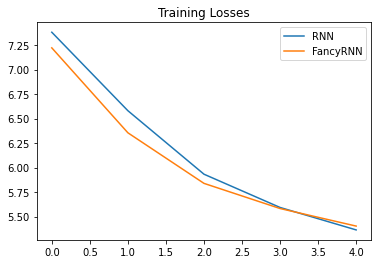

In [45]:
fig, ax = plt.subplots()
vanila_rnnlm_loss = np.array(vanila_rnnlm_loss)
fancy_rnnlm_loss = np.array(fancy_rnnlm_loss)
plt.plot(vanila_rnnlm_loss, label='RNN')
plt.plot(fancy_rnnlm_loss, label='FancyRNN')
plt.title("Training Losses")
plt.legend()

### Generating new text with RNNLM
Write the code to generate new text segments from the RNNLM. Produce several outputs from both VanilaRNN and FancyRNN to compare the quality of 2 models.

In [46]:
def generate_text(rnnlm, seed_text, length, **params):
    """
    Params:
    rnnlm: the language model
    seed_text: a string of initial text
    length: the length of the generated text
    params: other params
    """
    seed_text = seed_text.lower().split() # ['students', 'open', 'their', 'bag']

    # translate words to id
    sentence_id = []
    for word in seed_text:
      sentence_id.append(word2id[word])    # ['123', '435', '135', '14']
    input_tensor = torch.LongTensor(sentence_id).to(device)

    # put seed_text through the language model
    for i in range(length):
      h0 = torch.zeros(1, hidden_size).to(device)
      output_text, hs = rnnlm(input_tensor, h0)
      output_text = output_text[-1]
      output_text = torch.squeeze(output_text)

      # take the word with the highest probability
      argmax_id = torch.argmax(output_text).item()
      sentence_id.append(argmax_id)            # ['123', '435', '135', '14', '78']
      input_tensor = torch.LongTensor(sentence_id).to(device)

    # translate id to words
    output_sentence = []
    for id in sentence_id:
      output_sentence.append(id2word[id])
    output_sentence = ' '.join(output_sentence)

    return output_sentence

In [50]:
seed_text = input('Enter your initial text: ')
input_text = seed_text.lower().split()
key_not_exist = False
for key in input_text:
  if key not in vocabulary:
    key_not_exist = True
    print("The word \"", key, "\" is not in the vocabulary")

if not (key_not_exist):
  output_text1 = generate_text(rnnlm=vanila_rnnlm, seed_text=seed_text, length=100)
  output_text2 = generate_text(rnnlm=fancy_rnnlm, seed_text=seed_text, length=100)
  print('{:<25}{:<30}'.format('VanilaRNN output: ', output_text1))
  print('{:<25}{:<30}'.format('FancyRNN output: ', output_text2))

Enter your initial text: The military force at Little Rock under Dunnington
VanilaRNN output:        the military force at little rock under dunnington , and the british academy , and the british academy , and the british academy , and the british academy , and the british academy , and the british academy , and the british academy , and the british academy , and the british academy , and the british academy , and the british academy , and the british academy , and the british academy , and the british academy , and the british academy , and the british academy , and the british academy , and the british academy , and the british academy , and the british academy
FancyRNN output:         the military force at little rock under dunnington . he was a relationship with the british academy to the british academy to the british academy , and was invited to the british academy to the british academy , and was invited to the british academy to the british academy , and was invited to the brit

### Perplexity (+2 bonus points)
Compute the perplexity of the models. The lower the perplexity, the higher your score.

Perplexity of the model:

$$ P = \exp(\frac 1 T \sum_{t=1}^T -\log\hat{y}^{(t)}_{x_{t+1}}) = \exp(J(\theta)) $$
Where J(θ) is Cross entropy loss of the test set.

In [51]:
import math

def perplexity(rnnlm, corpus):
    CE_loss = nn.CrossEntropyLoss()
    
    total_loss = 0
    for sentence in corpus:
      h0 = torch.zeros(1, hidden_size).to(device)

      input_sentence = torch.LongTensor(sentence[:-1]).to(device)
      target_sentence = torch.LongTensor(sentence[1:]).to(device)
      ys, hs = rnnlm(input_sentence, h0)
      ys = torch.cat(ys)

      loss = CE_loss(ys, target_sentence)
      total_loss += loss.item()
    
    # normalize
    avg_loss = total_loss / len(corpus)
    # perplexity = exp(CE_Loss)
    perp = math.exp(avg_loss)
    
    return perp

In [52]:
vanila_rnnlm_perp = perplexity(rnnlm=vanila_rnnlm, corpus=corpus_test)
fancy_rnnlm_perp = perplexity(rnnlm=fancy_rnnlm, corpus=corpus_test)
print('{:<25}{:<30.4f}'.format('Vanila_RNNLM perplexity: ', vanila_rnnlm_perp))
print('{:<25}{:<30.4f}'.format('Fancy_RNNLM perplexity: ', fancy_rnnlm_perp))

Vanila_RNNLM perplexity: 8025.6180                     
Fancy_RNNLM perplexity:  6687.6528                     


## Word Embedding (1 point + 1 bonus point)

Now you have trained your RNNLM, the `torch.nn.Embedding` layer in your model stores the embeddings of words in the dictionary. You can use dimensionality reduction algorithms such as PCA and TSNE to visualize the word embeddings.
Produce a 2D plot of 100 to 1000 words and write a short analysis of the plot (e.g. the clusters of words with similar meaning, arithmetic operations you can apply on these words).

This word embedding visualization is from the Fancy RNN model's nn.Embedding layer

In [53]:
import pandas as pd
from sklearn.manifold import TSNE

In [54]:
# get the word embedding and turn into np array
word_embedding = fancy_rnn.embeddings
word_embedding = (word_embedding.cpu().weight).detach().numpy()
# get the vocabulary list
vocab = list(id2word.values())

n_words = 200
word_embedding = word_embedding[:n_words]
vocab = vocab[:n_words]

print(word_embedding.shape)   # n_words x embedding dim
print(len(vocab))             # n_words

(200, 24)
200


In [55]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_features = tsne_model.fit_transform(word_embedding)
tsne_features[:5]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


array([[ 3.7482257,  1.5864038],
       [ 1.9918253, -3.8627098],
       [ 5.3314104, -1.5154754],
       [-0.7865476,  2.2453218],
       [ 3.7874775, -5.1544533]], dtype=float32)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21704 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20315 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22899 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23401 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21016 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20134 missing from current font.
  font.set_

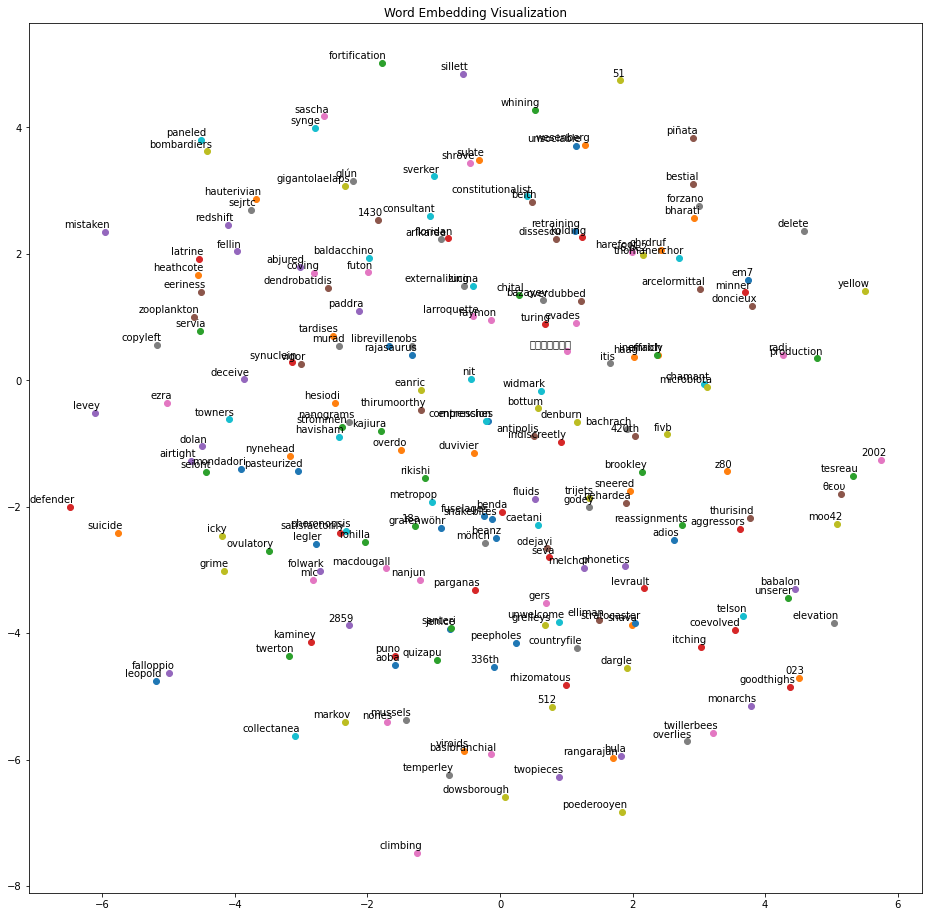

In [58]:
x = []
y = []
for value in tsne_features:
    x.append(value[0])
    y.append(value[1])
    
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(vocab[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right',va='bottom')
plt.title("Word Embedding Visualization")
plt.show()